## Finite Notebook Fun for Lessons 1/2

Note: the lesson notebooks are not reviewed and only serve for the purpose of in-class illustrations.

In [3]:
from random import random
import numpy as np

from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

In [4]:
# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs, history1, history2):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - no dropout')
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(0, 0.7)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - no dropout')
    ax3.plot(history1.history['categorical_accuracy'])
    ax3.plot(history1.history['val_categorical_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(0.7, 1.0)


    ax2 = axs[0, 1]
    ax2.set_title('loss - with dropout')
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(0, 0.7)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - with dropout')
    ax4.plot(history2.history['categorical_accuracy'])
    ax4.plot(history2.history['val_categorical_accuracy'])
    ax4.set_ylim(0.7, 1.0)

### 1. Checking a few things about cross-entropy

Imagine a probability distribution $p$ cross 5 outcomes:

In [5]:
p = np.array([0.3,0.2,0.1,0.25,0.15])
print(p)

[0.3  0.2  0.1  0.25 0.15]


Calculate the entropy:

In [6]:
S = -(0.3 * np.log2(0.3) + 0.2 * np.log2(0.2) + 0.1 * np.log2(0.1) + 0.25 * np.log2(0.25) + 0.15 * np.log2(0.15))
print(S)

2.228212945841001


Explicit, but tedious and silly. Better way? Use vectors:

In [7]:
S = - np.dot(p, np.log2(p))
print(S)

2.228212945841001


Same result. Good. 

Now imagine a 2nd distribution q which is close to $p$ but differs a bit. 
Construct it via a small $\delta$ vector which has a mean of zero, and whose scale is a small number $\epsilon$: 

In [8]:
def create_q(p0, epsilon=0.03):

    delta = epsilon * np.random.random(5)
    delta = delta - np.mean(delta)
    
    return (p0 + delta)

q = create_q(p)
print('q: ', q)

q:  [0.30333603 0.19627223 0.09443645 0.24949366 0.15646162]


What is the cross entropy?

In [9]:
ce = -np.dot(p, np.log2(q))
print(ce)

2.228718124868872


Close! Smaller or bigger than entropy?

In [10]:
print((ce - S) > 0)

True


Let's try that for many q:

In [11]:
for attempt in range(5):
    q = create_q(p)
    ce = -np.dot(p, np.log2(q))
    #print(q)
    print('ce > S? ', (ce-S)>0)
    

ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True
ce > S?  True


Indeed... $ce$ is always larger than $S$ ('experimentally verified', but should be proven). $ce = S$ when $q=p$, therefor minimizing $ce$ drives $q \rightarrow p$.

### 2. A few basic words on vector and matrix calculations 

Imagine a neural net where the dimension  of the incoming layer is $4$, and the next layer has dimension $3$. Let $x$ be the input. What are the dimensions of the weight matrix $W$ and bias vector $b$ in $$z = f(x W + b)?$$    

$W$ needs to 'translate' a 4-d vector into a 3-d vector. Hence dim$(W) = 4 \times 3$.

Each output neuron has its own bias value, dim$(b) = 3$.

Example:

In [12]:
x = np.array([1,1,2,2])

W = np.array([[-1,-3,-2],[-2,3,-6],[4,-2,3], [-1, 5, 1]]) 


b = np.array([-1, -2, -3])

In [13]:
print('x shape: ', x.shape)
print('W shape: ', W.shape)
print('b shape: ', b.shape)

x shape:  (4,)
W shape:  (4, 3)
b shape:  (3,)


In [14]:
z = x.dot(W) + b
z

array([ 2,  4, -3])

Now let's add the non-linearity, sigmoid to be concrete. The non-linearity is an element-wise operation. (The last output layer at the end however is different.)

In [15]:
def sigmoid(y):
    return 1/(1 + np.exp(-y))

In [16]:
h = sigmoid(z)
h

array([0.88079708, 0.98201379, 0.04742587])

### 3. Familiarization with the Output Layer and Softmax operation

Imagine your output layer (which does not have a non-linearity) returns these 5 numbers:

In [17]:
o = 10 * np.random.random(5) - 5
print('o: ', o)

o:  [ 4.21079502 -0.13998141  3.56866729 -1.06345951  0.86665689]


In a classification problem, these 5 numbers would be the output for each class. They can be large, small, positive, negative, etc. 

We want to model probabilities though. Hence, we need to convert the output to 5 values that are **1) positive** and **2) sum to 1**.

Let's first exponentiate all values:

In [18]:
exp_o = np.exp(o)
print('outputs: ', exp_o)

outputs:  [67.4101108   0.8693744  35.46929119  0.34525931  2.37894448]


Great. All numbers are positive. But they don't sum to $1$. Simple solution: divide each value by the sum of all values:

In [19]:
sum_exp_o = np.sum(exp_o)
print('sum of all output values: ', sum_exp_o)

sum of all output values:  106.47298018066569


In [20]:
p = exp_o/sum_exp_o
print('model probabilities p: ', p)

model probabilities p:  [0.63311941 0.00816521 0.33312951 0.00324269 0.02234318]


In [21]:
p = exp_o/sum_exp_o
print('model probabilities q: ', p)

model probabilities q:  [0.63311941 0.00816521 0.33312951 0.00324269 0.02234318]


In [22]:
np.sum(p)

1.0

Cool! Sums to 1 as desired. (Not a surprise.)

What happens if I add a constant to each value in $o$? How is softmax affected?

In [23]:
o_2 = o + 1

In [24]:
exp_o_2 = np.exp(o_2)
print('outputs: ', exp_o_2)

outputs:  [183.23967923   2.36320463  96.4155297    0.93851212   6.46664156]


In [25]:
sum_exp_o_2 = np.sum(exp_o_2)

In [26]:
q = exp_o_2/sum_exp_o_2
print('new probabilities q_2: ', q)

new probabilities q_2:  [0.63311941 0.00816521 0.33312951 0.00324269 0.02234318]


Same!

### 4. Most Basic Keras Intro

Simple 3-class classification model. This is only intended to illustrate the TensorFlow/Keras concepts. See: https://www.tensorflow.org/guide/keras

There are two types of formalisms: 1) **Sequential** models, and 2) **Functional API**. The former is a little simpler, but it only supports (as the name says) sequential architectures. The Functional API approach is extremely flexible and will be introduced later. (And that is the one we will generally use.)   


But for this first test we set up a **Sequential** model, wrapped in a function:

In [27]:
def create_model(dropout=0.0, num_neurons=10):
    # Define 'sequential' model (vs. 'functional'... we'll discuss later.)
    model = tf.keras.Sequential([

    # Let's go nuts in terms of layers and neurons per layer and actively try to overfit
        
    # Add 5 densely-connected layers with num_neurons units followed by dropout to the model:
    
    layers.Dense(num_neurons, activation='relu',
                 #kernel_initializer=tf.keras.initializers.glorot_normal ,
                 input_shape=(20,)),         # '20' is the number of features of the input

    # add a droput layer
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),
        
    layers.Dense(num_neurons, activation='relu'),
    layers.Dropout(dropout),

    # Create a softmax layer with 3 output units - 
    # as required by the labels being 3 dimensional representinbg 3 classes:
    layers.Dense(3, activation='softmax')])
    
    # Compile model. Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])
    
    return model

Create some fake input data ():

In [28]:
def random_one_hot_labels(num_examples, num_classes, dim):
    
    #create random data
    base_data = np.random.random((num_examples, dim))
    
    #create random labels
    classes = np.random.randint(0, num_classes, num_examples)
    labels = np.zeros((num_examples, num_classes))
    labels[np.arange(num_examples), classes] = 1
    
    # hide a small signal in the data
    label_to_data_signal = np.reshape(np.array(np.random.random(num_classes * dim)), 
                                      (num_classes, dim))
    
    signals = np.matmul(labels, label_to_data_signal)                    
    
    data = base_data + 1/2 * signals
    
    return data, labels



data, labels = random_one_hot_labels(10000, 3, 20)

Create a model without dropout:

In [29]:
model_0 = create_model(0.0, 200)

2022-01-13 13:14:26.478425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Make a couple of predictions. Are they random?

In [30]:
model_0.predict(data[:2])

array([[0.31912327, 0.32569855, 0.3551782 ],
       [0.31510773, 0.31990603, 0.3649862 ]], dtype=float32)

Pretty much...
Now then train your mode:

In [31]:
history_0 = model_0.fit(data, labels,   
          validation_split=0.2,
          epochs=100, 
          batch_size=50, 
          verbose=0)

model_0.fit(data, labels,   
          validation_split=0.2,
          epochs=1, 
          batch_size=50, 
          verbose=2)

160/160 - 1s - loss: 0.0137 - categorical_accuracy: 0.9951 - val_loss: 0.7375 - val_categorical_accuracy: 0.8840 - 504ms/epoch - 3ms/step


Now create and train a model with dropout:

In [32]:
model_2 = create_model(0.2)

history_2 = model_2.fit(data, labels,   
          validation_split=0.2,
          epochs=100, 
          batch_size=50, 
          verbose=0)

model_2.fit(data, labels,   
          validation_split=0.2,
          epochs=1, 
          batch_size=50, 
          verbose=1)

160/160 [==============================] - 0s 844us/step - loss: 0.3874 - categorical_accuracy: 0.8668 - val_loss: 0.3405 - val_categorical_accuracy: 0.8650


Let's look at the behavior:

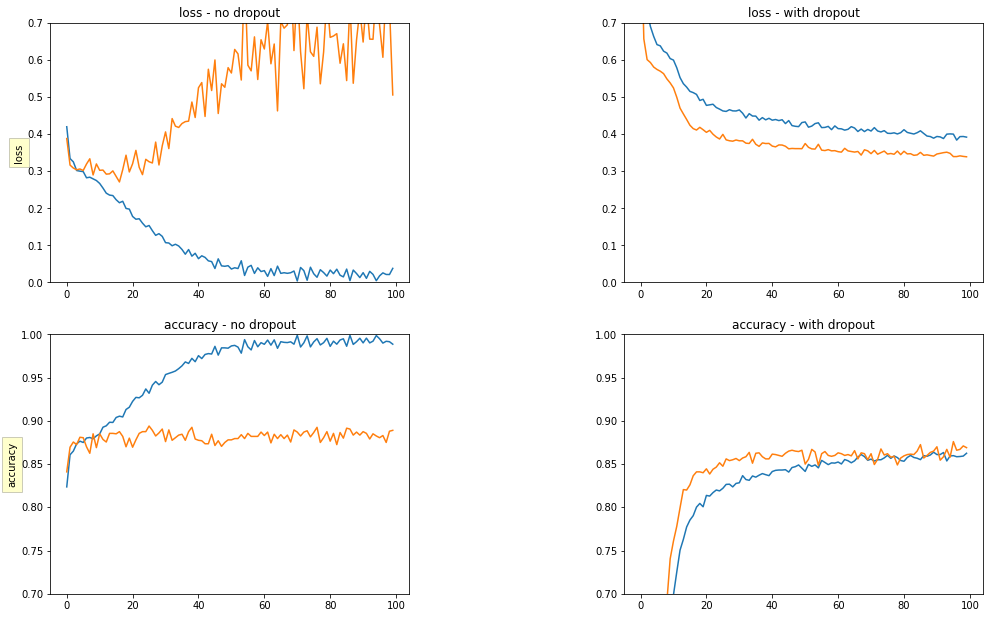

In [33]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history_0, history_2)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

What is the interpretation? (The example is surely very artificial.)

### 5. Effect of Layer Normalization

In the last step, let's quickly introduce the **Functional API** and then specifically looks at the effect of Layer Normalization:

In [34]:
try: 
    del function_model_layer_norm
except:
    pass

# Functional API! 
# Define inputs, then network architecture build as a series of: 
#     layer_output = layer(earlier_layer_output)
# then define model through input list and output list 

inputs = layers.Input(shape=(20,))

dense_layer =  layers.Dense(5, activation='relu',
                              kernel_initializer=tf.keras.initializers.glorot_normal,
                              name='layer_1')         

dense_out = dense_layer(inputs)

# now add layer normalization layer
final_out = layers.LayerNormalization()(dense_out)

# use actual 2 layers as model outputs to see the effect of the layer normalization:
function_model_layer_norm = tf.keras.models.Model(inputs=[inputs], outputs=[dense_out, final_out])

In [35]:
pred_layer_after_dense, pred_layer_after_norm = function_model_layer_norm.predict(data[:2], batch_size=2)
pred_layer_after_dense

array([[0.        , 1.3623097 , 0.92837346, 1.1766145 , 0.        ],
       [0.        , 0.2724806 , 0.30532187, 1.0727984 , 0.        ]],
      dtype=float32)

In [36]:
pred_layer_after_norm

array([[-1.1883106 ,  1.14614   ,  0.40254787,  0.82793313, -1.1883106 ],
       [-0.8366369 , -0.14607829, -0.06284735,  1.8821993 , -0.8366369 ]],
      dtype=float32)

Let's look at the sum and standard deviations of the output:

In [37]:
np.sum(pred_layer_after_norm, axis=-1)

array([-2.3841858e-07, -1.1920929e-07], dtype=float32)

In [38]:
np.std(pred_layer_after_norm, axis=-1)

array([0.9985308, 0.9967833], dtype=float32)

Looks reasonable?